In [575]:
import pandas as pd
import matplotlib.pyplot as plt

In [576]:
# Get raw data
russel_data_raw = pd.read_csv('data/russel_1000_growth.csv')
constituents_data_raw = pd.read_csv('data/constituents_data.csv')
fundamental_raw = pd.read_csv('data/fundamental.csv')

/var/folders/cr/kh6dk_xn6jj4m9j7d9fl94y80000gn/T/ipykernel_51110/1602549683.py:3: DtypeWarning: Columns (9,24,49,58) have mixed types. Specify dtype option on import or set low_memory=False.
  constituents_data_raw = pd.read_csv('data/constituents_data.csv')
/var/folders/cr/kh6dk_xn6jj4m9j7d9fl94y80000gn/T/ipykernel_51110/1602549683.py:4: DtypeWarning: Columns (12,13,17,18,20,25,26,30,32,33,34,35,650,656,668,669,674,678,679) have mixed types. Specify dtype option on import or set low_memory=False.
  fundamental_raw = pd.read_csv('data/fundamental.csv')


In [577]:
# Get tickers
tickers = russel_data_raw['Ticker']
tickers.head()

0    AAPL
1    NVDA
2    MSFT
3    AMZN
4    META
Name: Ticker, dtype: object

In [578]:
# Get constituents data
constituents_data_raw.shape

(57731, 64)

**Process stock daily data**

In [579]:
# Field mapping for the columns
field_mapping = {
    "PERMNO": {
        "Description": "Unique identifier for each stock.",
        "Usage": "Used for joining datasets in WRDS.",
        "Example": "e.g., 10104",
    },
    "TICKER": {
        "Description": "Ticker symbol of the stock.",
        "Usage": "Identifies the stock in reports.",
        "Example": "e.g., AAPL"
    },
    "COMNAM": {
        "Description": "Company name.",
        "Usage": "Helps verify and align stock information.",
        "Example": "e.g., Apple Inc.",
        "name": "Company Name"
    },
    "date": {
        "Description": "Date of the record.",
        "Usage": "Ensures the time range of data is consistent.",
        "Example": "e.g., 2024-11-30",
        "name": "Date"
    },
    "PRC": {
        "Description": "Closing price of the stock (adjusted).",
        "Usage": "Used to calculate price growth or market capitalization.",
        "Example": "e.g., 150.25",
        "name": "Price"
    },
    "RET": {
        "Description": "Total return (including dividends).",
        "Usage": "Target variable for predicting future returns.",
        "Example": "e.g., 0.0523 (5.23%)",
        "name": "Total Ret"
    },
    "RETX": {
        "Description": "Price return (excluding dividends).",
        "Usage": "Used for return analysis and excess return calculations.",
        "Example": "e.g., 0.0485 (4.85%)",
        "name": "Price Ret Ex-Dividend"
    },
    "vwretd": {
        "Description": "Value-weighted market total return.",
        "Usage": "Serves as the market benchmark for excess return.",
        "Example": "e.g., 0.0324 (3.24%)",
        "name": "Weighted Mkt Return"
    },
    "VOL": {
        "Description": "Volume of shares traded.",
        "Usage": "Used for liquidity analysis.",
        "Example": "e.g., 1000000 (1M shares)",
        "name": "Volume"
    },
    "CFACPR": {
        "Description": "Price adjustment factor.",
        "Usage": "Adjusts historical price data for splits/dividends.",
        "Example": "e.g., 1.05",
        "name": "Price Adj Factor"
    },
    "CFACSHR": {
        "Description": "Share adjustment factor.",
        "Usage": "Adjusts historical share data for splits.",
        "Example": "e.g., 0.95",
        "name": "Share Adj Factor"
    },
    "SICCD": {
        "Description": "Standard Industry Classification code.",
        "Usage": "Analyzes industry-specific patterns.",
        "Example": "e.g., 7370 (Technology)",
        "name": "Industry Code"
    },
    "EXCHCD": {
        "Description": "Exchange code for the stock.",
        "Usage": "Identifies the stock's trading market.",
        "Example": "e.g., 3 (NASDAQ)",
        "name": "Exchange Code"
    },
    "DIVAMT": {
        "Description": "Dividend amount per share.",
        "Usage": "Used to calculate dividend yield.",
        "Example": "e.g., 0.50 (50 cents per share)",
        "name": "Dividend"
    },
    "BID": {
        "Description": "Lowest bid price of the stock for the day.",
        "Usage": "Provides additional liquidity information.",
        "Example": "e.g., 149.50",
        "name": "Price Low"
    },
    "ASK": {
        "Description": "Highest ask price of the stock for the day.",
        "Usage": "Provides additional liquidity information.",
        "Example": "e.g., 150.75",
        "name": "Price High"
    },
    "SHROUT": {
        "Description": "Number of shares outstanding.",
        "Usage": "Used to calculate market capitalization.",
        "Example": "e.g., 500000000 (500M shares)",
        "name": "Shares Outstanding"
    }
}

# SICCD to Industry Mapping (Short Names)
siccd_mapping = {
    range(100, 1000): "Agriculture",
    range(1000, 1500): "Mining",
    range(1500, 1800): "Construction",
    range(2000, 4000): "Manufacturing",
    range(4000, 5000): "Transport",
    range(5000, 6000): "Retail",
    range(6000, 6800): "Finance",
    range(7000, 9000): "Services",
    range(9100, 10000): "Public",
}
def map_siccd_to_short_industry(siccd):
    for key, value in siccd_mapping.items():
        if siccd in key:
            return value
    return "Unknown"


# Add a new field `is_numeric` to indicate if the field is a numeric type
for key, value in field_mapping.items():
    if key in ["PERMNO", "PRC", "RET", "RETX", "vwretd", "VOL", "CFACPR", "CFACSHR", "DIVAMT", "BID", "ASK", "SHROUT"]:
        value["is_numeric"] = True
    else:
        value["is_numeric"] = False

# Convert the field mapping dictionary to a pandas DataFrame
field_mapping_df = pd.DataFrame.from_dict(field_mapping, orient='index')

# Get field data mapping
required_cols = field_mapping.keys()
rename_mapping = {}

for i in field_mapping:
    rename_mapping[i] = field_mapping[i].get("name", i)
rename_mapping

{'PERMNO': 'PERMNO',
 'TICKER': 'TICKER',
 'COMNAM': 'Company Name',
 'date': 'Date',
 'PRC': 'Price',
 'RET': 'Total Ret',
 'RETX': 'Price Ret Ex-Dividend',
 'vwretd': 'Weighted Mkt Return',
 'VOL': 'Volume',
 'CFACPR': 'Price Adj Factor',
 'CFACSHR': 'Share Adj Factor',
 'SICCD': 'Industry Code',
 'EXCHCD': 'Exchange Code',
 'DIVAMT': 'Dividend',
 'BID': 'Price Low',
 'ASK': 'Price High',
 'SHROUT': 'Shares Outstanding'}

In [580]:
# Add a new field `is_numeric` to indicate if the field is a numeric type
for key, value in field_mapping.items():
    if key in ["PERMNO", "PRC", "RET", "RETX", "vwretd", "VOL", "CFACPR", "CFACSHR", "DIVAMT", "BID", "ASK", "SHROUT"]:
        value["is_numeric"] = True
    else:
        value["is_numeric"] = False

# Convert the field mapping dictionary to a pandas DataFrame
field_mapping_df = pd.DataFrame.from_dict(field_mapping, orient='index')

In [581]:
# Process data and check missing data
constituents_data_raw = constituents_data_raw[required_cols].rename(columns=rename_mapping)
# Drop the missing columns and create a clean copy
constituents_data_cleaned = constituents_data_raw.dropna(subset=['TICKER', "Price"]).copy()

# Add Industry column safely
constituents_data_cleaned["Industry"] = constituents_data_cleaned["Industry Code"].apply(map_siccd_to_short_industry)

# Check missing counts
missing_count = constituents_data_cleaned.isnull().sum()
missing_count

PERMNO                       0
TICKER                       0
Company Name                 0
Date                         0
Price                        0
Total Ret                    0
Price Ret Ex-Dividend        0
Weighted Mkt Return          0
Volume                       0
Price Adj Factor             0
Share Adj Factor             0
Industry Code                0
Exchange Code                0
Dividend                 47182
Price Low                    0
Price High                   0
Shares Outstanding           0
Industry                     0
dtype: int64

In [582]:
constituents_data_cleaned.head(10)

,PERMNO,TICKER,Company Name,Date,Price,Total Ret,Price Ret Ex-Dividend,Weighted Mkt Return,Volume,Price Adj Factor,Share Adj Factor,Industry Code,Exchange Code,Dividend,Price Low,Price High,Shares Outstanding,Industry
0,10104,ORCL,ORACLE CORP,2010-01-29,23.0600,-0.057888,-0.059927,-0.037172,6068156.0,1.0,1.0,7370.0,3.0,0.05,23.06,23.07,5011220.0,Services
1,10104,ORCL,ORACLE CORP,2010-02-26,24.6500,0.068951,0.068951,0.034744,5771538.0,1.0,1.0,7370.0,3.0,NaN,24.64,24.65,5015000.0,Services
2,10104,ORCL,ORACLE CORP,2010-03-31,25.7100,0.043002,0.043002,0.063668,6618577.0,1.0,1.0,7370.0,3.0,NaN,25.68,25.69,5019091.0,Services
3,10104,ORCL,ORACLE CORP,2010-04-30,25.8675,0.008071,0.006126,0.020036,5580407.0,1.0,1.0,7370.0,3.0,0.05,25.86,25.87,5029523.0,Services
4,10104,ORCL,ORACLE CORP,2010-05-28,22.5700,-0.127477,-0.127477,-0.079240,7406752.0,1.0,1.0,7370.0,3.0,NaN,22.56,22.58,5026000.0,Services
5,10104,ORCL,ORACLE CORP,2010-06-30,21.4600,-0.049180,-0.049180,-0.050780,6282398.0,1.0,1.0,7370.0,3.0,NaN,21.45,21.46,5026000.0,Services
6,10104,ORCL,ORACLE CORP,2010-07-30,23.6400,0.103914,0.101584,0.070360,6447152.0,1.0,1.0,7370.0,3.0,0.05,23.63,23.64,5026000.0,Services
7,10104,ORCL,ORACLE CORP,2010-08-31,21.8450,-0.075931,-0.075931,-0.042864,5306818.0,1.0,1.0,7370.0,3.0,NaN,21.87,21.88,5025000.0,Services
8,10104,ORCL,ORACLE CORP,2010-09-30,26.8500,0.229114,0.229114,0.091628,10619524.0,1.0,1.0,7370.0,3.0,NaN,26.86,26.87,5027114.0,Services
9,10104,ORCL,ORACLE CORP,2010-10-29,29.3800,0.096089,0.094227,0.038591,7612951.0,1.0,1.0,7370.0,3.0,0.05,29.40,29.41,5027114.0,Services


In [583]:
constituents_data_cleaned['Date'] = pd.to_datetime(constituents_data_cleaned['Date'])

# Extract quarterly information from the 'date' column
constituents_data_cleaned['Quarter'] = constituents_data_cleaned['Date'].dt.to_period('Q')

# Ensure columns used in aggregation are numeric
numeric_cols = ['Price', 'Total Ret', 'Price Ret Ex-Dividend', 'Weighted Mkt Return', 
                'Volume', 'Dividend', 'Price Low', 'Price High', 'Shares Outstanding']
for col in numeric_cols:
    if col in constituents_data_cleaned.columns:
        constituents_data_cleaned[col] = pd.to_numeric(constituents_data_cleaned[col], errors='coerce')

In [584]:
# Add additional columns
constituents_data_cleaned = constituents_data_cleaned.copy()

# Solve missing value
constituents_data_cleaned.fillna(0, inplace=True)

# Get Excess Return and Market Cap
constituents_data_cleaned["Excess Return"] = (
    constituents_data_cleaned["Total Ret"] - constituents_data_cleaned["Weighted Mkt Return"]
)
constituents_data_cleaned["Mkt Cap"] = (
    constituents_data_cleaned["Price"] * constituents_data_cleaned["Shares Outstanding"]
)
# Get Price Growth Rate 
constituents_data_cleaned["Price Growth Rate"] = (
    constituents_data_cleaned.groupby("PERMNO")["Price"].transform(lambda x: x.pct_change())
)
constituents_data_cleaned = constituents_data_cleaned.dropna(subset=["Price Growth Rate"])

Transform constituent data to monthly data

In [585]:
# Aggregate data to quarterly level
quarterly_data = constituents_data_cleaned.groupby(['PERMNO', 'Company Name', 'TICKER', 'Quarter']).agg({
    'Price': 'mean',                     # Average price within the quarter
    'Total Ret': 'sum',                  # Total return within the quarter
    'Price Ret Ex-Dividend': 'mean',     # Average price return excluding dividends
    'Weighted Mkt Return': 'mean',       # Average weighted market return
    'Volume': 'sum',                     # Total volume within the quarter
    'Dividend': 'sum',                   # Total dividend paid within the quarter
    'Price Low': 'min',                  # Minimum price within the quarter
    'Price High': 'max',                 # Maximum price within the quarter
    'Shares Outstanding': 'mean'         # Average shares outstanding
    
}).reset_index()

quarterly_data['Excess Return'] = quarterly_data['Total Ret'] - quarterly_data['Weighted Mkt Return']
quarterly_data['Mkt Cap'] = quarterly_data['Price'] * quarterly_data['Shares Outstanding']

# To calculate Price Growth Rate (quarter-over-quarter)
quarterly_data['Price Growth Rate'] = (
    quarterly_data.groupby('TICKER')['Price']
    .transform(lambda x: x.pct_change(fill_method=None))
)
quarterly_data.reset_index(drop=True, inplace=True)
quarterly_data = quarterly_data.dropna()

In [586]:
quarterly_data.head(10)

,PERMNO,Company Name,TICKER,Quarter,Price,Total Ret,Price Ret Ex-Dividend,Weighted Mkt Return,Volume,Dividend,Price Low,Price High,Shares Outstanding,Excess Return,Mkt Cap,Price Growth Rate
1,10104,ORACLE CORP,ORCL,2010Q2,23.299167,-0.168586,-0.056844,-0.036661,19269557.0,0.05,21.45,25.87,5.027174e+06,-0.131925,1.171290e+08,-0.074696
2,10104,ORACLE CORP,ORCL,2010Q3,24.111667,0.257097,0.084922,0.039708,22373494.0,0.05,21.87,26.87,5.026038e+06,0.217389,1.211862e+08,0.034872
3,10104,ORACLE CORP,ORCL,2010Q4,29.241667,0.173943,0.057360,0.036963,19703951.0,0.05,27.03,31.31,5.043511e+06,0.136980,1.474807e+08,0.212760
4,10104,ORACLE CORP,ORCL,2011Q1,32.787500,0.068267,0.022223,0.020227,16622553.0,0.05,32.02,33.39,5.057979e+06,0.048040,1.658385e+08,0.121260
5,10104,ORACLE CORP,ORCL,2011Q2,34.363333,-0.009274,-0.003690,-0.001599,17548016.0,0.06,32.89,36.02,5.064677e+06,-0.007675,1.740392e+08,0.048062
6,10104,ORACLE CORP,ORCL,2011Q3,29.130000,-0.127187,-0.043003,-0.055027,25659706.0,0.06,28.07,30.59,5.053706e+06,-0.072160,1.472144e+08,-0.152294
7,10104,ORACLE CORP,ORCL,2011Q4,29.923333,-0.082840,-0.028309,0.037184,19652413.0,0.06,25.63,32.77,5.034146e+06,-0.120024,1.506384e+08,0.027234
8,10104,ORACLE CORP,ORCL,2012Q1,28.875000,0.135941,0.044534,0.039784,21098553.0,0.06,28.19,29.27,4.993314e+06,0.096157,1.441820e+08,-0.035034
9,10104,ORACLE CORP,ORCL,2012Q2,28.523333,0.032653,0.010198,-0.011423,18276647.0,0.06,26.48,29.71,4.920871e+06,0.044076,1.403596e+08,-0.012179
10,10104,ORACLE CORP,ORCL,2012Q3,31.103333,0.060865,0.019615,0.021046,13704804.0,0.06,30.19,31.64,4.844187e+06,0.039819,1.506704e+08,0.090452


In [587]:
quarterly_data.describe()

,PERMNO,Price,Total Ret,Price Ret Ex-Dividend,Weighted Mkt Return,Volume,Dividend,Price Low,Price High,Shares Outstanding,Excess Return,Mkt Cap,Price Growth Rate
count,18580.000000,18580.000000,18580.000000,18580.000000,18580.000000,1.858000e+04,18580.000000,18580.000000,18580.000000,1.858000e+04,18580.000000,1.858000e+04,18580.000000
mean,55749.809150,127.828542,0.054728,0.017272,0.009984,1.915448e+06,0.344583,120.143964,135.238443,3.619684e+05,0.044744,3.619656e+07,0.065470
std,32370.732735,267.867114,0.220710,0.074168,0.027446,4.755546e+06,5.579977,255.022182,281.109401,9.562285e+05,0.209476,1.334642e+08,1.790476
min,10104.000000,-14.016667,-1.470855,-0.538961,-0.090778,1.500000e+02,0.000000,0.064000,0.159200,2.333333e+02,-1.422381,-4.851667e+05,-17.888889
25%,16932.000000,31.957617,-0.045538,-0.016293,-0.001090,2.947905e+05,0.000000,29.590000,34.080000,5.500175e+04,-0.050020,3.257780e+06,-0.045042
50%,67598.000000,64.405000,0.055708,0.017402,0.014876,7.279365e+05,0.016750,60.095000,68.245000,1.249380e+05,0.042617,8.473866e+06,0.040191
75%,86211.000000,130.090831,0.153893,0.050188,0.026235,1.639556e+06,0.320000,121.755000,137.692500,2.973085e+05,0.134372,2.503472e+07,0.119365
max,93436.000000,4378.386720,11.926947,3.975649,0.114146,1.083043e+08,569.739990,4307.529790,4518.319820,1.694229e+07,11.900712,6.217526e+09,154.114504


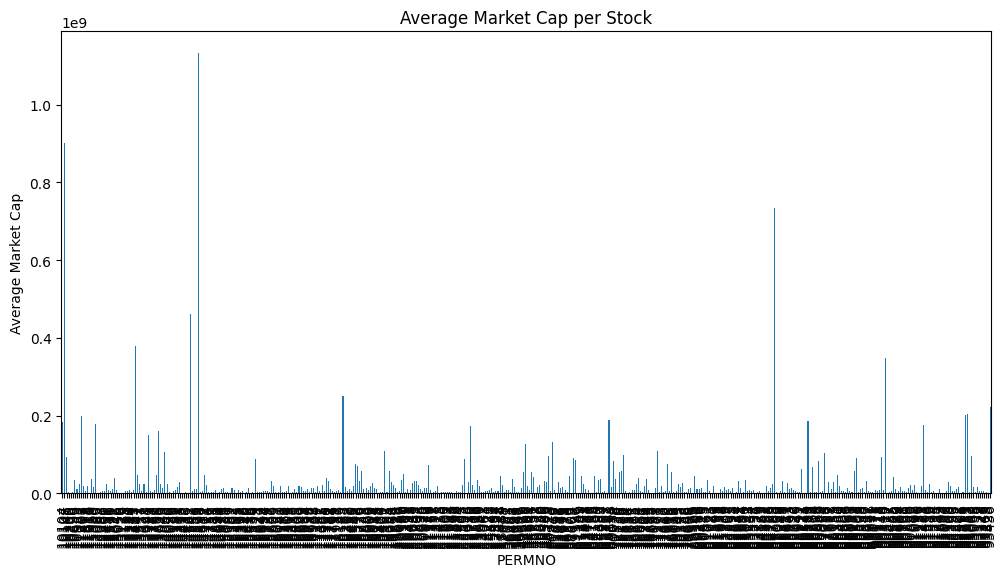

In [588]:
# Get average market cap
market_cap = quarterly_data.groupby("PERMNO")["Mkt Cap"].mean()
market_cap.plot(kind='bar', figsize=(12, 6))
plt.title("Average Market Cap per Stock")
plt.xlabel("PERMNO")
plt.ylabel("Average Market Cap")
plt.show()


In [589]:
unique_permnos = constituents_data_cleaned["PERMNO"].unique()
with open("promo.txt", "w") as file:
    for permno in unique_permnos:
        file.write(f"{permno}\n")

**Process Fundamental Data**

In [590]:
fundamental_raw

,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1045,31/03/2010,2010,1.0,12,INDL,C,D,STD,AAL,...,4,4512,605.0,600.0,C,TX,0.0,www.aa.com,NaN,NaN
1,1045,30/06/2010,2010,2.0,12,INDL,C,D,STD,AAL,...,4,4512,605.0,600.0,C,TX,0.0,www.aa.com,NaN,NaN
2,1045,30/09/2010,2010,3.0,12,INDL,C,D,STD,AAL,...,4,4512,605.0,600.0,C,TX,0.0,www.aa.com,NaN,NaN
3,1045,31/12/2010,2010,4.0,12,INDL,C,D,STD,AAL,...,4,4512,605.0,600.0,C,TX,0.0,www.aa.com,NaN,NaN
4,1045,31/03/2011,2011,1.0,12,INDL,C,D,STD,AAL,...,4,4512,605.0,600.0,C,TX,0.0,www.aa.com,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24672,176621,30/09/2023,2023,3.0,12,INDL,C,D,STD,USD,...,1,6722,NaN,NaN,NaN,MD,NaN,www.proshares.com/funds/usd.html,NaN,NaN
24673,176621,31/12/2023,2023,4.0,12,INDL,C,D,STD,USD,...,1,6722,NaN,NaN,NaN,MD,NaN,www.proshares.com/funds/usd.html,NaN,NaN
24674,176621,31/03/2024,2024,1.0,12,INDL,C,D,STD,USD,...,1,6722,NaN,NaN,NaN,MD,NaN,www.proshares.com/funds/usd.html,NaN,NaN
24675,176621,30/06/2024,2024,2.0,12,INDL,C,D,STD,USD,...,1,6722,NaN,NaN,NaN,MD,NaN,www.proshares.com/funds/usd.html,NaN,NaN


In [638]:
# Add a "rename_to" field with more descriptive, human-readable names for each field
compustat_field_mapping = {
    "tic": {
        "name": "TICKER"
    },
    "datacqtr": {
        "Description": "Quaterly Data",
        "Usage": "Describe the quately data",
        "name": "Quarter"
    },
    "conm": {
        "name": "Company Name"
    },
    "datadate": {
        "Description": "The date of the data record, typically represents the fiscal quarter or year-end date.",
        "Usage": "Used for time-based analysis or filtering.",
        "Example": "e.g., 2023-12-31",
        "name": "Date"
    },
    "saleq": {
        "Description": "Quarterly revenue (sales), representing total sales or operating revenue for the period.",
        "Usage": "Used to calculate revenue growth rates.",
        "Example": "e.g., 5000000 (5M)",
        "name": "Quart Rev"
    },
    "ibq": {
        "Description": "Quarterly net income, representing the company's earnings after taxes and expenses.",
        "Usage": "Used to calculate earnings growth rates.",
        "Example": "e.g., 1000000 (1M)",
        "name": "Quart NI"
    },
    "ceqq": {
        "Description": "Common equity, representing the total shareholder equity available to common shareholders.",
        "Usage": "Used to calculate debt-to-equity ratios.",
        "Example": "e.g., 2000000 (2M)",
        "name": "Equity"
    },
    "ltq": {
        "Description": "Total liabilities, representing the total debt and other obligations owed by the company.",
        "Usage": "Used to calculate debt-to-equity ratios.",
        "Example": "e.g., 3000000 (3M)",
        "name": "Liabilities"
    },
    "revtq": {
        "Description": "Revenue (total sales or operating revenue) for the period, another indicator of income.",
        "Usage": "Used to calculate financial performance metrics.",
        "Example": "e.g., 5000000 (5M)",
        "name": "Revenue"
    },
    "sic": {
        "Description": "Standard Industrial Classification (SIC) code, representing the company's primary industry.",
        "Usage": "Used to classify and analyze companies by industry.",
        "Example": "e.g., 7370 (Technology)",
        "name": "Industry Code"
    },
    'atq': {
        'name': "Asset"
    },
    'actq': {
        'name': "Current Asset"
    }
}

# Convert the updated mapping to a DataFrame for review
required_fields = list(compustat_field_mapping.keys())
available_fields = [field for field in required_fields if field in fundamental_raw.columns]
fundamental_raw_filtered = fundamental_raw[available_fields]
rename_mapping = {key: value['name'] for key, value in compustat_field_mapping.items() if key in fundamental_raw.columns}
fundamental_raw_filtered = fundamental_raw_filtered.rename(columns=rename_mapping)
fundamental_raw_filtered = fundamental_raw_filtered.dropna(subset=['Equity', 'Quarter']).copy()
fundamental_raw_filtered['Quarter'] = pd.PeriodIndex(
    fundamental_raw_filtered['Quarter'], freq='Q'
)
fundamental_raw_filtered['Liabilities'] = fundamental_raw_filtered['Asset'] - fundamental_raw_filtered['Equity']


fundamental_raw_filtered.head(50)


,TICKER,Quarter,Company Name,Date,Quart Rev,Quart NI,Equity,Liabilities,Revenue,Industry Code,Asset,Current Asset,EPS
0,AAL,2010Q1,AMERICAN AIRLINES GROUP INC,31/03/2010,5068.0,-505.0,-3892.0,29417.0,5068.0,4512,25525.0,6834.0,0.129753
1,AAL,2010Q2,AMERICAN AIRLINES GROUP INC,30/06/2010,5674.0,-11.0,-3930.0,29815.0,5674.0,4512,25885.0,7344.0,0.002799
2,AAL,2010Q3,AMERICAN AIRLINES GROUP INC,30/09/2010,5842.0,143.0,-3643.0,29000.0,5842.0,4512,25357.0,6837.0,-0.039253
3,AAL,2010Q4,AMERICAN AIRLINES GROUP INC,31/12/2010,5586.0,-98.0,-3945.0,29033.0,5586.0,4512,25088.0,6838.0,0.024842
4,AAL,2011Q1,AMERICAN AIRLINES GROUP INC,31/03/2011,5533.0,-436.0,-3949.0,31062.0,5533.0,4512,27113.0,8825.0,0.110408
5,AAL,2011Q2,AMERICAN AIRLINES GROUP INC,30/06/2011,6114.0,-286.0,-4509.0,30296.0,6114.0,4512,25787.0,7997.0,0.063429
6,AAL,2011Q3,AMERICAN AIRLINES GROUP INC,30/09/2011,6376.0,-162.0,-4833.0,29552.0,6376.0,4512,24719.0,6838.0,0.033520
7,AAL,2011Q4,AMERICAN AIRLINES GROUP INC,31/12/2011,5999.0,-1095.0,-7111.0,30959.0,5999.0,4512,23848.0,6757.0,0.153987
8,AAL,2012Q1,AMERICAN AIRLINES GROUP INC,31/03/2012,6037.0,-1660.0,-8686.0,33197.0,6037.0,4512,24511.0,7778.0,0.191112
9,AAL,2012Q2,AMERICAN AIRLINES GROUP INC,30/06/2012,6453.0,-240.0,-8968.0,33694.0,6453.0,4512,24726.0,7984.0,0.026762


In [592]:
# Sanity check
asset_columns = [col for col in fundamental_raw.columns if 'asset' in col.lower() or col in ['atq', 'actq']]
print("Possible asset-related columns:", asset_columns)

Possible asset-related columns: ['actq', 'atq']


In [593]:
fundamental_raw_filtered.shape

(23094, 13)

In [594]:
fundamental_raw_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23094 entries, 0 to 24542
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype        
---  ------         --------------  -----        
 0   TICKER         23094 non-null  object       
 1   Quarter        23094 non-null  period[Q-DEC]
 2   Company Name   23094 non-null  object       
 3   Date           23094 non-null  object       
 4   Quart Rev      23078 non-null  float64      
 5   Quart NI       23080 non-null  float64      
 6   Equity         23094 non-null  float64      
 7   Liabilities    23094 non-null  float64      
 8   Revenue        22927 non-null  float64      
 9   Industry Code  23094 non-null  int64        
 10  Asset          23094 non-null  float64      
 11  Current Asset  19468 non-null  float64      
 12  EPS            23080 non-null  float64      
dtypes: float64(8), int64(1), object(3), period[Q-DEC](1)
memory usage: 2.5+ MB


In [595]:
ticker_change_dict = {
    'FI': 'FISV', 'FB': 'META', 'MUSA': 'MUSA', 'GOOG': 'GOOGL', 
    'ARES': 'ARES', 'LBRDA': 'LBRDK', 'FRPT': 'FRPT', 'BLD': 'BLD', 
    'TRU': 'TRU', 'SIOX': 'SIOX', 'AM': 'AM', 'DELL': 'DELL', 
    'TW': 'TW', 'DT': 'DT', 'GHIV': 'GHIV', 'SNOW': 'SNOW', 
    'BSY': 'BSY', 'COIN': 'COIN', 'APP': 'APP', 'PATH': 'PATH', 
    'S': 'S', 'HCP': 'HCP', 'NU': 'NU', 'SN': 'SN', 'BYI': 'BYI', 
    'HRB': 'HRB', 'OLED': 'PANL', 'MFE': 'MFE', 'MWW': 'MWW', 
    'AVTA': 'AVTA', 'EXEL': 'EXEL', 'AXON': 'AAXN', 'NANO': 'NANO', 
    'FNJN': 'FNJN', 'SMCI': 'SMCI'
}

Build data

In [627]:
# Unify the ticker
fundamental_raw_filtered['TICKER'] = fundamental_raw_filtered['TICKER'].replace(ticker_change_dict)
quarterly_data['TICKER'] = quarterly_data['TICKER'].replace(ticker_change_dict)

merged_ticker_data = []
unique_tickers = quarterly_data['TICKER'].unique()

for ticker in unique_tickers:
    quarterly_subset = quarterly_data[quarterly_data['TICKER'] == ticker]
    fundamental_subset = fundamental_raw_filtered[fundamental_raw_filtered['TICKER'] == ticker]
    merged = pd.merge(
        quarterly_subset,
        fundamental_subset,
        on=['TICKER', 'Quarter'],
        # how='join'
    )
    merged_ticker_data.append(merged)
final_merged_data = pd.concat(merged_ticker_data, ignore_index=True)


In [625]:
unmatched_tickers = set(quarterly_data['TICKER']) - set(fundamental_raw_filtered['TICKER'])
print("Unmatched Tickers:", unmatched_tickers)

# 检查 Quarter 是否完全匹配
unmatched_quarters = set(quarterly_data['Quarter']) - set(fundamental_raw_filtered['Quarter'])
print("Unmatched Quarters:", unmatched_quarters)

Unmatched Tickers: 40
Unmatched Quarters: set()


In [631]:
final_merged_data

,PERMNO,Company Name_x,TICKER,Quarter,Price,Total Ret,Price Ret Ex-Dividend,Weighted Mkt Return,Volume,Dividend,...,Date,Quart Rev,Quart NI,Equity,Liabilities,Revenue,Industry Code,Asset,Current Asset,EPS
0,10104,ORACLE CORP,ORCL,2010Q2,23.299167,-0.168586,-0.056844,-0.036661,19269557.0,0.05,...,31/05/2010,9505.000,2363.000,30798.000,30780.000,9505.000,7372,61578.000,27004.000,0.076726
1,10104,ORACLE CORP,ORCL,2010Q3,24.111667,0.257097,0.084922,0.039708,22373494.0,0.05,...,31/08/2010,7502.000,1352.000,32106.000,33149.000,7502.000,7372,65255.000,30264.000,0.042111
2,10104,ORACLE CORP,ORCL,2010Q4,29.241667,0.173943,0.057360,0.036963,19703951.0,0.05,...,30/11/2010,8582.000,1871.000,34412.000,32831.000,8582.000,7372,67243.000,32723.000,0.054371
3,10104,ORACLE CORP,ORCL,2011Q1,32.787500,0.068267,0.022223,0.020227,16622553.0,0.05,...,28/02/2011,8763.000,2115.000,36617.000,31049.000,8763.000,7372,67666.000,32459.000,0.057760
4,10104,ORACLE CORP,ORCL,2011Q2,34.363333,-0.009274,-0.003690,-0.001599,17548016.0,0.06,...,31/05/2011,10775.000,3209.000,39776.000,33759.000,10775.000,7372,73535.000,39174.000,0.080677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19564,93436,TESLA MOTORS INC,TSLA,2016Q1,204.299997,-0.002394,-0.000798,0.004675,3161030.0,0.00,...,31/03/2016,1147.048,-282.267,970.365,8221.337,1147.048,3711,9191.702,3239.543,-0.290887
19565,93436,TESLA MOTORS INC,TSLA,2016Q2,225.423330,-0.074034,-0.024678,0.009668,3605766.0,0.00,...,30/06/2016,1270.017,-293.188,2520.294,9348.658,1270.017,3711,11868.952,5203.705,-0.116331
19566,93436,TESLA MOTORS INC,TSLA,2016Q3,216.943327,-0.028624,-0.009541,0.014876,2071813.0,0.00,...,30/09/2016,2298.436,21.878,2680.488,9911.909,2298.436,3711,12592.397,5172.412,0.008162
19567,93436,TESLA MOTORS INC,TSLA,2016Q4,200.273330,0.055241,0.018414,0.012569,2790785.0,0.00,...,31/12/2016,2284.631,-121.337,4752.911,17911.165,2284.631,3711,22664.076,6259.796,-0.025529


In [665]:
# Add Earning growth rate,revenue growth, P/E ratio
final_merged_data.sort_values(by=['TICKER', 'Quarter'], inplace=True)
final_merged_data['EPS'] = (final_merged_data['Quart NI'] * 1000)/( final_merged_data['Shares Outstanding'])
final_merged_data['Revenue Growth'] = final_merged_data.groupby('TICKER')['Quart Rev'].transform(lambda x: x.pct_change()) 
final_merged_data['P/E Ratio Quarter'] = final_merged_data['Price'] / final_merged_data['EPS']
final_merged_data['P/E Ratio Annual'] = final_merged_data['P/E Ratio Quater'] / 4
final_merged_data['Earnings Growth Rate'] = final_merged_data.groupby('TICKER')['EPS'].transform(lambda x: x.pct_change()) 

# Drop rows with NaN values in the calculated change percentage columns
final_merged_data = final_merged_data.dropna(subset=['Revenue Growth', 'Earnings Growth Rate'])

# Reset index after dropping rows
final_merged_data.reset_index(drop=True, inplace=True)

# Display the processed DataFrame
final_merged_data.head()

/var/folders/cr/kh6dk_xn6jj4m9j7d9fl94y80000gn/T/ipykernel_51110/3660368851.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  final_merged_data['Revenue Growth'] = final_merged_data.groupby('TICKER')['Quart Rev'].transform(lambda x: x.pct_change())


,PERMNO,Company Name_x,TICKER,Quarter,Price,Total Ret,Price Ret Ex-Dividend,Weighted Mkt Return,Volume,Dividend,...,Industry Code,Asset,Current Asset,EPS,Revenue Growth,P/E Ratio,Earnings Growth Rate,P/E Ratio Quater,P/E Ratio Annual,P/E Ratio Quarter
0,24643,ALCOA INC,AA,2016Q3,10.280000,0.103560,0.033579,0.014876,10605153.0,0.03,...,3334,17305.0,3622.0,-0.007602,0.002583,-1.352209e+09,-0.818230,-1352.208927,-338.052232,-1352.208927
1,24643,ALCOA INC,AA,2016Q4,28.720000,-0.055884,-0.055884,-0.021544,2770322.0,0.00,...,3334,16741.0,3181.0,-0.285388,0.089309,-1.006349e+08,36.539336,-100.634880,-25.158720,-100.634880
2,21020,AMERICAN AIRLINES GROUP INC,AAL,2015Q1,49.920000,-0.004967,-0.002335,0.006118,7988790.0,0.10,...,4512,46754.0,14129.0,1.339128,-0.032776,3.727799e+07,0.594095,37.277992,9.319498,37.277992
3,21020,AMERICAN AIRLINES GROUP INC,AAL,2015Q2,43.530000,-0.263242,-0.088379,-0.000063,7058747.0,0.10,...,4512,47868.0,14109.0,2.476880,0.101760,1.757453e+07,0.849621,17.574531,4.393633,17.574531
4,21020,AMERICAN AIRLINES GROUP INC,AAL,2015Q3,39.303333,-0.025152,-0.009215,-0.027191,6966704.0,0.10,...,4512,48715.0,13706.0,2.560302,-0.011176,1.535105e+07,0.033681,15.351051,3.837763,15.351051


In [666]:
final_merged_data.columns
for i in final_merged_data.columns:
    print(i)

PERMNO
Company Name_x
TICKER
Quarter
Price
Total Ret
Price Ret Ex-Dividend
Weighted Mkt Return
Volume
Dividend
Price Low
Price High
Shares Outstanding
Excess Return
Mkt Cap
Price Growth Rate
Company Name_y
Date
Quart Rev
Quart NI
Equity
Liabilities
Revenue
Industry Code
Asset
Current Asset
EPS
Revenue Growth
P/E Ratio
Earnings Growth Rate
P/E Ratio Quater
P/E Ratio Annual
P/E Ratio Quarter


In [669]:
# Define the columns to keep
columns_to_keep = [
    "Company Name_x",
    "TICKER",
    "Quarter",
    "Price",
    "Total Ret",
    "Price Ret Ex-Dividend",
    "Weighted Mkt Return",
    "Volume",
    "Dividend",
    "Price Low",
    "Price High",
    "Shares Outstanding",
    "Excess Return",
    "Mkt Cap",
    "Price Growth Rate",
    "Quart Rev",
    "Quart NI",
    "Equity",
    "Liabilities",
    "Revenue",
    "Industry Code",
    "Asset",
    "Current Asset",
    "EPS",
    "Revenue Growth",
    "P/E Ratio",
    "Earnings Growth Rate",
    "P/E Ratio Annual",
    "P/E Ratio Quarter"
]

# Filter the DataFrame to keep only the specified columns
final_filtered_data = final_merged_data[columns_to_keep]

# Display the first few rows of the filtered DataFrame
final_filtered_data.head()


,Company Name_x,TICKER,Quarter,Price,Total Ret,Price Ret Ex-Dividend,Weighted Mkt Return,Volume,Dividend,Price Low,...,Revenue,Industry Code,Asset,Current Asset,EPS,Revenue Growth,P/E Ratio,Earnings Growth Rate,P/E Ratio Annual,P/E Ratio Quarter
0,ALCOA INC,AA,2016Q3,10.280000,0.103560,0.033579,0.014876,10605153.0,0.03,10.07,...,2329.0,3334,17305.0,3622.0,-0.007602,0.002583,-1.352209e+09,-0.818230,-338.052232,-1352.208927
1,ALCOA INC,AA,2016Q4,28.720000,-0.055884,-0.055884,-0.021544,2770322.0,0.00,28.72,...,2537.0,3334,16741.0,3181.0,-0.285388,0.089309,-1.006349e+08,36.539336,-25.158720,-100.634880
2,AMERICAN AIRLINES GROUP INC,AAL,2015Q1,49.920000,-0.004967,-0.002335,0.006118,7988790.0,0.10,47.90,...,9827.0,4512,46754.0,14129.0,1.339128,-0.032776,3.727799e+07,0.594095,9.319498,37.277992
3,AMERICAN AIRLINES GROUP INC,AAL,2015Q2,43.530000,-0.263242,-0.088379,-0.000063,7058747.0,0.10,39.93,...,10827.0,4512,47868.0,14109.0,2.476880,0.101760,1.757453e+07,0.849621,4.393633,17.574531
4,AMERICAN AIRLINES GROUP INC,AAL,2015Q3,39.303333,-0.025152,-0.009215,-0.027191,6966704.0,0.10,38.80,...,10706.0,4512,48715.0,13706.0,2.560302,-0.011176,1.535105e+07,0.033681,3.837763,15.351051


In [671]:
# Save data
final_merged_data.to_csv("final_merged_data.csv", index=False)